# Build a model to classify topics for Telegram channels

**Pre-req**
1. Download csv from gdrive with channels and save to ``data/external/telegram_channels.csv``
2. Run ``python -m src.train.download`` to get posts and meta-data

**Steps**
1. Load data:
    - posts from channels
    - channel titles and descriptions
    - channel topics
2. Build a training dataset:
    1. Merge
    2. Select inputs
    3. Split into train/val
3. Build models:
    1. Embed text
    2. Train a classifier
    3. Select best
4. Evaluate on test data and save best

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm, notebook_tqdm

from torchtext import data
import re
# custom path
os.chdir('..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data prep

In [741]:
THESTACK = "./data/raw/thestack/"

MAXCHARS = 500
MAXBLOCKS = 10

### Load channels

In [742]:
files = Path(THESTACK).rglob("*.txt")

thestack = []
for f in files:
    content = f.read_text()
    n_blocks, _ = divmod(len(content), MAXCHARS)
    for i in range(min(n_blocks, MAXBLOCKS)):
        block = content[i*MAXCHARS: (i+1)*MAXCHARS]
        thestack.append((block, f.parent.name))
    
thestack = pd.DataFrame(thestack, columns=["content", "lang"])

In [743]:
thestack.sample(5)

,content,lang
368,"Datum,NieuwOpgenomenVerdacht\n2020-02-27,0\n20...",TGLANG_LANGUAGE_CSV
2385,t;\n\n/**\n * Tests UNICAST2. Created to test ...,TGLANG_LANGUAGE_JAVA
4105,"0_"")) return false;\n\n size_t numLevels = ...",TGLANG_LANGUAGE_CPLUSPLUS
5172,"t=""server"" Text=""暂存"" CssClass=""m_btn_w2"" Comma...",TGLANG_LANGUAGE_ASP
8278,Unidos em 2018. As resoluções do Conselho de ...,TGLANG_LANGUAGE_JSON


In [744]:
thestack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10363 entries, 0 to 10362
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  10363 non-null  object
 1   lang     10363 non-null  object
dtypes: object(2)
memory usage: 162.0+ KB


### EDA

In [745]:
from src.train.plot_utils import barplots

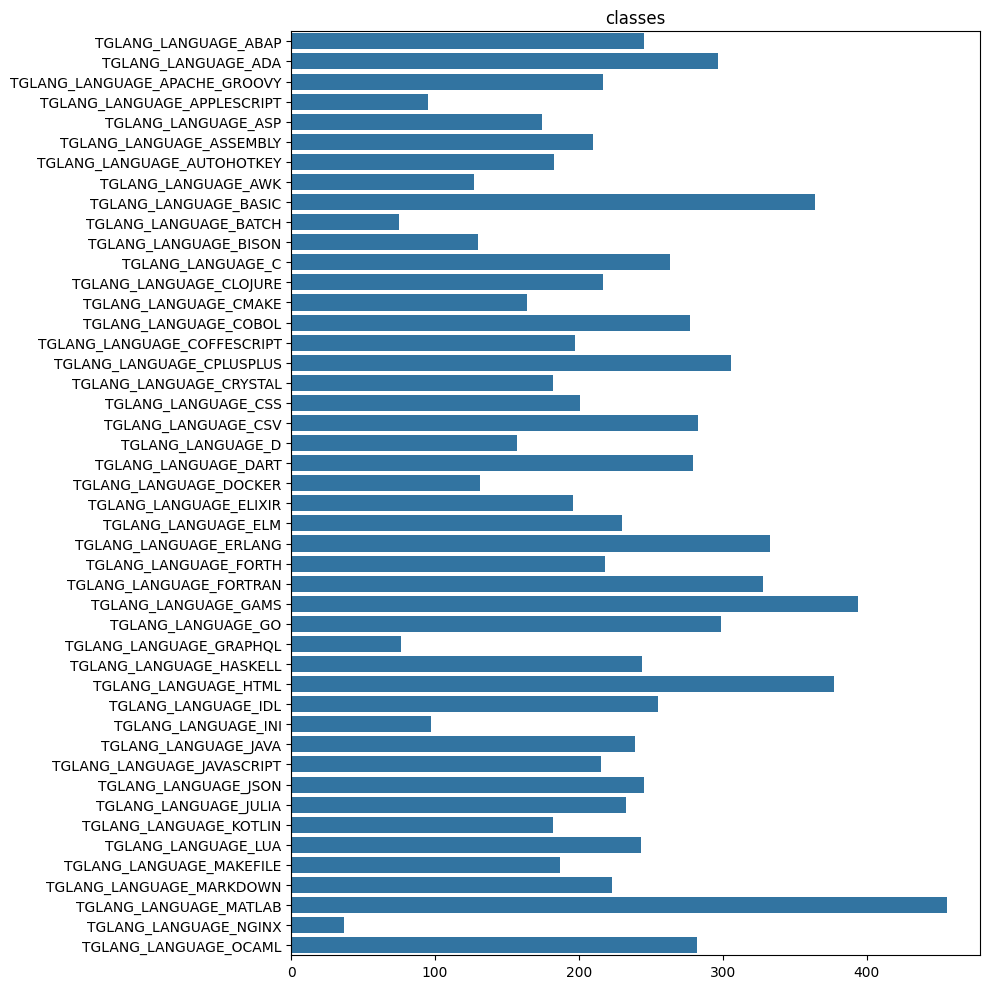

In [746]:
barplots({
    'classes': thestack['lang']
}, 1, 1, horizontal=True, fig_dims=(10, 10))

### Load stopwords

In [747]:
STOPWORDS = {
#     'en': 'data/external/en_stopwords.txt',
#     'ru': 'data/external/ru_stopwords.txt',
}

In [748]:
# stopwords = [Path(f).read_text().strip().split('\n') for l,f in STOPWORDS.items()]

# stopwords = sum(stopwords, [])

stopwords = [
    "yy",
    "you",
    "yes",
    "year",
    "year_all",
    "x86",
    "x3",
    "x2",
    "word",
    "written",
    "work",
    "x1",
    "hello",
    "world",
        "µg",
    "zone",
    "zero",
    "za",
    "your",
    "www",
    "writing",
    "would",
    "without",
    "windows",
    "will",
    "프록시",
    "애플리케이션",
    "대한",
    "表示视频片段",
    "表示",
    "结尾",
    "支持",
    "当字符串以",
    "单位为像素",
    "为100像素",
]

len(stopwords)

35

## Experiments

**Hyper-parameters:**
- [x] topics: primary only, primary + secondary
- [x] inputs: title, description, posts
- [x] preprocessing: raw, lemmas
- [x] vectorizers: tf-idf, bow
- [x] clf: xgb, nb, etc.

In [749]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB

# from xgboost import XGBClassifier

import itertools

In [750]:
class Trainer:
    """ prapre inputs, vectorize texts and run a classifier """
    def __init__(self, input_fields, preprocessing, vect, est):
        self.INPUT_FIELDS = input_fields
        self.vect = VECTORIZERS[vect]
        self.vect.preprocessor = lambda x: x
        self.vect.lowercase = False
        self.clf = ESTIMATORS[est]
        assert preprocessing in ['raw']
        self.preprocessing = preprocessing
        
    def prepare_data(self, is_final):
        # split into  train and test
        one, self.test_inputs = train_test_split(thestack, test_size=0.2, random_state=24, shuffle=True,)
        comb_datasets = [one, self.test_inputs] if is_final else [one]
        self.train_inputs = pd.concat(comb_datasets, axis=0)
        # x and y
        self.y_train = self.train_inputs['lang']
        self.y_test = self.test_inputs['lang']
        self.X_train = self.vect.fit_transform(self.train_inputs['content'])
        self.X_test = self.vect.transform(self.test_inputs['content'])
        
        
    def run_eval(self, final=False):
        """ prepare inputs and run clf evaluation """
        self.prepare_data(final)
        # fit and eval
        self.clf.fit(self.X_train, self.y_train)
        self.predictions = pd.DataFrame({
                    'true': trainer.test_inputs['lang'],
                    'predicted': trainer.clf.predict(trainer.X_test)
                })
        score = self.predictions.apply(lambda x: x['predicted'] in x['true'], axis=1).mean()
        return score

### Set hyper-parameters

In [755]:
INPUTS = [
    'content',
]

PREPROCESSING = [
    'raw',
#     'lemma',
]

vect_params = dict(
    max_df=0.05, 
    min_df=5,
    max_features=1000,
    binary=False, 
    ngram_range=(1,1), 
    stop_words=stopwords, 
)
VECTORIZERS = {
    'tfidf': TfidfVectorizer(**vect_params),
    'bow': CountVectorizer(**vect_params),
}


ESTIMATORS = dict(
#     xgb = XGBClassifier(objective='multi:softmax'),
#     forest = RandomForestClassifier(),
#     logreg = LogisticRegression(),
#     knn = KNeighborsClassifier(),
#     tree = ExtraTreeClassifier(),
#     svm = SVC(),
#     linsvm = LinearSVC(),
    cnb = ComplementNB(),
    mnb = MultinomialNB(),
)

In [756]:
input_combinations = [INPUTS] #list(itertools.combinations(INPUTS, r=2)) + [INPUTS]

train_params = list(itertools.product( 
                                input_combinations,
                                      PREPROCESSING,
                                VECTORIZERS.keys(), 
                                ESTIMATORS.keys()))

len(train_params)

4

### Run experiments

In [757]:
results = []

for params in notebook_tqdm(train_params, desc='# experiments'):
    trainer = Trainer(*params)
    score = trainer.run_eval()
    params += (score,)
    results.append(params)
                
results = pd.DataFrame(results, columns=['input_fields', 'preprocessing','vect', 'est', 'score'])

# experiments: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


In [758]:
print(results.sort_values('score', ascending=False).to_markdown())

|    | input_fields   | preprocessing   | vect   | est   |    score |
|---:|:---------------|:----------------|:-------|:------|---------:|
|  3 | ['content']    | raw             | bow    | mnb   | 0.678726 |
|  1 | ['content']    | raw             | tfidf  | mnb   | 0.650748 |
|  0 | ['content']    | raw             | tfidf  | cnb   | 0.581766 |
|  2 | ['content']    | raw             | bow    | cnb   | 0.559093 |


### Review errors

In [759]:
from sklearn.metrics import top_k_accuracy_score

#### Train

In [760]:
best_params = results.sort_values("score", ascending=False).iloc[0].to_dict()
best_params.pop("score")

0.678726483357453

In [761]:
trainer = Trainer(**best_params)
s = trainer.run_eval(final=False)
print(s)

0.678726483357453


#### Classification report

In [762]:
from sklearn.metrics import classification_report

In [763]:
test_pred = trainer.clf.predict(trainer.X_test)

is_wrong = test_pred != trainer.y_test

errors = trainer.test_inputs[is_wrong]

errors['predicted'] = test_pred[is_wrong]

/var/folders/fg/vxz9bx5n1vvb2p8k4cr_wc9h0000gp/T/ipykernel_7910/1370959209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors['predicted'] = test_pred[is_wrong]


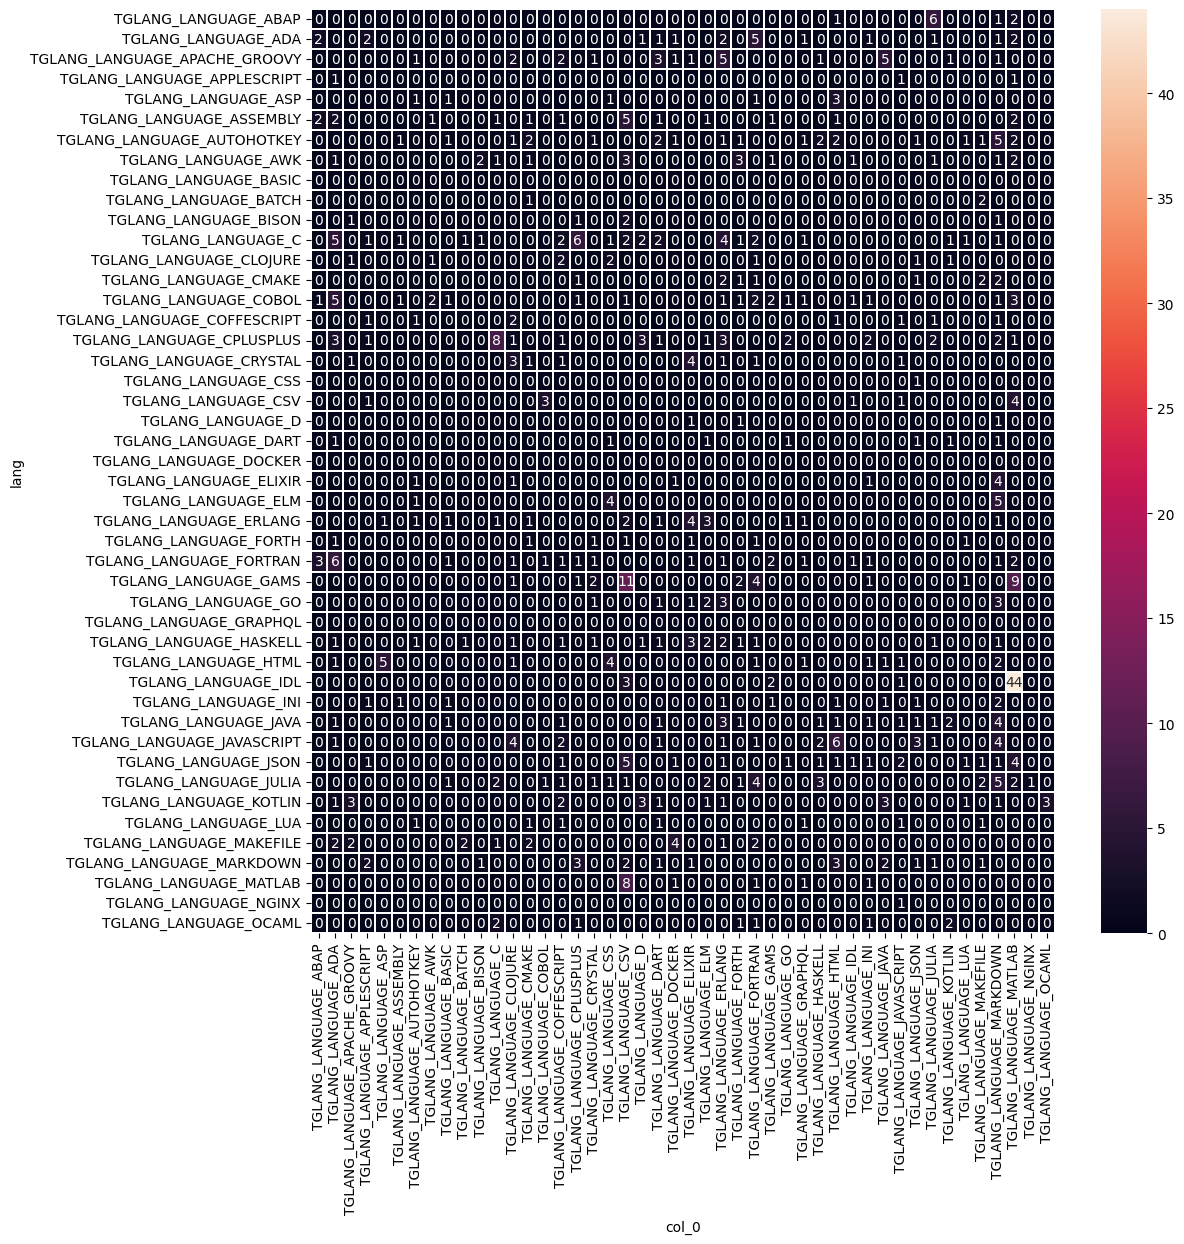

In [764]:
ct = pd.crosstab(trainer.y_test, test_pred)
for i,k in ct.iterrows():
    k[i] = 0


plt.figure(figsize=(12,12))
sns.heatmap(ct, annot=True, linewidths=0.01);

In [765]:
metrics = pd.DataFrame(classification_report(trainer.y_test, test_pred, output_dict=True, zero_division=0)).T

metrics = metrics.query("support > 0").sort_values('f1-score', ascending=True)

print(metrics.to_markdown())

|                               |   precision |    recall |   f1-score |     support |
|:------------------------------|------------:|----------:|-----------:|------------:|
| TGLANG_LANGUAGE_IDL           |    0.166667 | 0.0196078 |  0.0350877 |   51        |
| TGLANG_LANGUAGE_MARKDOWN      |    0.320513 | 0.581395  |  0.413223  |   43        |
| TGLANG_LANGUAGE_INI           |    0.4      | 0.444444  |  0.421053  |   18        |
| TGLANG_LANGUAGE_AWK           |    0.666667 | 0.32      |  0.432432  |   25        |
| TGLANG_LANGUAGE_AUTOHOTKEY    |    0.636364 | 0.35      |  0.451613  |   40        |
| TGLANG_LANGUAGE_JAVASCRIPT    |    0.633333 | 0.422222  |  0.506667  |   45        |
| TGLANG_LANGUAGE_C             |    0.636364 | 0.444444  |  0.523364  |   63        |
| TGLANG_LANGUAGE_CPLUSPLUS     |    0.634146 | 0.45614   |  0.530612  |   57        |
| TGLANG_LANGUAGE_JULIA         |    0.651163 | 0.5       |  0.565657  |   56        |
| TGLANG_LANGUAGE_APACHE_GROOVY |    0.7333

#### vectorizer

In [766]:
from collections import Counter

In [767]:
vocab = trainer.vect.vocabulary_

In [768]:
for x,_ in Counter(vocab).most_common(25):
    print(f'"{x}",')

"xs",
"xml",
"x_up",
"x_lo",
"write",
"wrapper",
"window",
"width",
"white",
"while",
"which",
"where",
"when",
"webkit",
"we",
"way",
"was",
"void",
"vlevo",
"view",
"version",
"vector",
"variables",
"variable",
"var",


In [769]:
Counter(vocab).most_common(100)

[('xs', 999),
 ('xml', 998),
 ('x_up', 997),
 ('x_lo', 996),
 ('write', 995),
 ('wrapper', 994),
 ('window', 993),
 ('width', 992),
 ('white', 991),
 ('while', 990),
 ('which', 989),
 ('where', 988),
 ('when', 987),
 ('webkit', 986),
 ('we', 985),
 ('way', 984),
 ('was', 983),
 ('void', 982),
 ('vlevo', 981),
 ('view', 980),
 ('version', 979),
 ('vector', 978),
 ('variables', 977),
 ('variable', 976),
 ('var', 975),
 ('values', 974),
 ('val', 973),
 ('v1', 972),
 ('utils', 971),
 ('util', 970),
 ('usr', 969),
 ('using', 968),
 ('users', 967),
 ('user', 966),
 ('useful', 965),
 ('used', 964),
 ('url', 963),
 ('uri', 962),
 ('update', 961),
 ('up', 960),
 ('unsigned', 959),
 ('unit', 958),
 ('under', 957),
 ('undefined', 956),
 ('ul', 955),
 ('uint64_t', 954),
 ('uint32_t', 953),
 ('uint', 952),
 ('ui', 951),
 ('types', 950),
 ('typeof', 949),
 ('txt', 948),
 ('two', 947),
 ('ts', 946),
 ('try', 945),
 ('transform', 944),
 ('tr', 943),
 ('topic', 942),
 ('top', 941),
 ('token', 940),
 ('

#### Fixes

**fixes**
- [ ] update stopwords
- [x] lemmas
- [x] remove single char terms
- [x] compare feature keywords against topic keywords
- [x] multi-class problem
- [x] only eng and rus chars
- [x] measure accuracy with top N predictions
- [x] use full data to train last
- [ ] sample weights for secondary
- [ ] bow to torchscript
- [x] apply sum normalization only then min prob threshold
- [x] fix when nothing predicted (add zero vectors as Other)
- [x] remove URL for lang detection

## Save models

In [770]:
from torch import nn
import torch
from torch.nn import functional as F
from typing import Dict, List, Tuple

In [771]:
TARGET_LABELS = Path("./src/tglang/langs_enum.txt").read_text().split("\n")

In [772]:
class NaiveBayes(nn.Module):
    """ Implement Multinomial and Complement NB inference """
    def __init__(self, nb, clf,):
        super().__init__()
        assert nb in ['cnb','mnb']
        self.nb = nb
        self.feature_log_prior = nn.Parameter(torch.tensor(clf.feature_log_prob_), requires_grad=False)
        self.class_log_prior = nn.Parameter(torch.tensor(clf.class_log_prior_), requires_grad=False)
        self.clf_labels = clf.classes_.tolist()
        self.target_labels = TARGET_LABELS
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        jll = torch.matmul(x.double(), self.feature_log_prior.T)
        if self.nb == 'cnb':
            if self.class_log_prior.size(0) == 1:
                jll += self.class_log_prior
        else:
            jll += self.class_log_prior
        log_prob = torch.logsumexp(jll, dim=1)
        log_prob = jll - torch.atleast_2d(log_prob).T
        prob = torch.exp(log_prob)
        return prob


class TextVectorizer(nn.Module):
    """ vectorize text using tf-idf or bow """
    def __init__(self, vect, vectorizer):
        super().__init__()
        assert vect in ['bow','tfidf']
        self.vocab = {k: torch.tensor(v) for k,v in vectorizer.vocabulary_.items()}
        self.vocab_len = len(self.vocab)
        if vect == 'tfidf':
            self.idf_diag = nn.Parameter(
                torch.tensor(vectorizer._tfidf._idf_diag.toarray()), 
                requires_grad=False)
            self.sublinear_tf = vectorizer.sublinear_tf
            self.norm = vectorizer.norm
            self.use_idf = vectorizer.use_idf
        else:
            self.idf_diag = nn.Parameter(torch.eye(self.vocab_len))
            self.sublinear_tf = False
            self.norm = None
            self.use_idf = False
            
        

    def count_vocab(self, doc: List[str]) -> torch.Tensor:
        """ return counts of each word from the vocab """
        feature_counter = torch.zeros(self.vocab_len, dtype=torch.long)
        for feature in doc:
            n = self.vocab.get(str(feature), torch.tensor(-1))
            if n.item() != -1:
                feature_idx = self.vocab[str(feature)]
                feature_counter[feature_idx] += 1
        return feature_counter
        
        
    def forward(self, batch: List[List[str]]) -> torch.Tensor:
        doc_counts: List[torch.Tensor] = [self.count_vocab(doc) for doc in batch]
        X = torch.stack(doc_counts,)
        if self.sublinear_tf:
            X = torch.log(X.double())
            X += 1
        if self.use_idf:
            X = torch.matmul(X.double(), self.idf_diag)
        if self.norm is not None:
            p = float(self.norm[-1])
            X = F.normalize(X.double(), p=p, dim=1)
        return X
    

class TgLang(nn.Module):
    """ vectorize input texts, classfy topics and decode predictions """
    def __init__(self, vect, clf):
        super().__init__()
        self.vect = vect
        self.clf = clf
        
        
    def select_top_class(self, probs: torch.Tensor) -> int:
        """ select classes with at least min prob and return a normalized dict mapping """
        if self.clf.nb == 'cnb' and probs.std(0) < 0.0001:
            return 0
        elif self.clf.nb == 'mnb' and probs.max() < 0.1:
            return 0
        max_index = torch.argmax(probs, 0)
        class_label = self.clf.clf_labels[max_index.item()]
        return self.clf.target_labels.index(class_label)
        
    
    def get_prob(self, batch: List[List[str]]) -> torch.Tensor:
        embeddings = self.vect(batch)
        probs = self.clf(embeddings)
        return probs
        
    
    def forward(self, batch: List[List[str]]) -> List[int]:
        probs = self.get_prob(batch)
        top_predictions = [self.select_top_class(probs[i]) for i in range(probs.size(0))]
        return top_predictions

### Test

In [773]:
tokenize_text = lambda x: x.split()

In [774]:

trainer = Trainer(**best_params)
_ = trainer.run_eval(final=False)

tglang = TgLang(
    TextVectorizer(best_params["vect"], trainer.vect),
    NaiveBayes(best_params["est"], trainer.clf),
)

In [775]:

batch = trainer.test_inputs.sample(5)
inputs = batch["content"].apply(tokenize_text).tolist()
gt = batch["lang"].tolist()

predictions = tglang(inputs)

In [776]:
for inp, out, index in zip(inputs, gt, predictions):
    print(f"Predicted {TARGET_LABELS[index]!r}. "
          f"True: {out!r}", 
          end="\n\n")
    print(inp[-100:])
    print("="*50, end="\n\n")

Predicted 'TGLANG_LANGUAGE_MATLAB'. True: 'TGLANG_LANGUAGE_MATLAB'

['00', '0.00', '-77.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '-1.00', '0.00', '0.00', '0.00', '0.00', '-91.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '-1.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '-97.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '-1.00', '0.00', '0.00', '0.00', '-19.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '-1.00', '0.00', '1.00', '0.00', '0.00', '0.00', '-46.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '-1.00', '0.00', '0.00', '-91.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '-1.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '-47.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00']

Predicted 'TGLANG_LANGUAGE_FORTRAN'. True: 'TGLANG_LANGUAGE_OCAML'

['shift_right}.', '*)', 'end', '(**', 'Infix', 'names', 'for', 'the', 'unsig

### Final training, convert and save

In [777]:
from sklearn.preprocessing import normalize

In [778]:

# # for last training increase train by test
# trainer = Trainer(**best_params)
# s = trainer.run_eval(final=True)
# print("SCORE: ", s)
# # save text vectorizer
# vect_scripted = torch.jit.script(TextVectorizer(best_params['vect'], trainer.vect))
# tokenizer = tokenize_text if best_params['preprocessing'] == 'raw' else lang_lemmatizer(l)
# batch = trainer.test_inputs['content'].apply(tokenize_text).tolist()
# vect_out = vect_scripted(batch)
# src_vects = trainer.X_test.toarray()
# assert np.allclose(src_vects, vect_out.numpy())
# # save classifier
# nb_scripted  = torch.jit.script(NaiveBayes(best_params['est'], trainer.clf))
# nb_out = nb_scripted(torch.tensor(trainer.X_test.toarray(), dtype=torch.double))
# assert np.allclose(trainer.clf.predict_proba(trainer.X_test), nb_out.numpy())
# save tgcat
tglang = torch.jit.script(tglang)
path = f'models/trained/tglang.pt'
torch.jit.save(tglang, path)
print('saved to', path)

saved to models/trained/tglang.pt


### Check file sizes

In [779]:
!du -h models/trained/* | sort -nr

5.1M	models/trained/tglang.pt
